In [1]:
import numpy as np
import cupy as cp
import sunpy.map,sunpy
import time
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.stats import gaussian_fwhm_to_sigma

from data_utils.calculating_DN import calculate_DN_alpha, calculate_DN_beta
from data_utils.calculating_DN import angle_point_num_alpha, angle_point_num_beta, wavelength_point_num
from data_utils.calculating_DN import calculating_DN
from scipy.optimize import curve_fit

from data_utils.data.aia_const import wavelength_list_aia_relative_Single_A

import pandas as pd

In [5]:
aia_file = 'data_utils\\data\\AIA\\aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits'
smap = sunpy.map.Map(aia_file)
image=smap.data

In [43]:
smap.meta

MetaDict([('simple', True),
          ('bitpix', -64),
          ('naxis', 2),
          ('naxis1', 4096),
          ('naxis2', 4096),
          ('bld_vers', 'V5R12X'),
          ('lvl_num', 1.5),
          ('t_rec', '2011-01-27T22:58:58Z'),
          ('trecstep', 1.0),
          ('trecepoc', '1977.01.01_00:00:00_TAI'),
          ('trecroun', 1),
          ('origin', 'SDO/JSOC-SDP'),
          ('date', '2012-10-12T19:36:57'),
          ('telescop', 'SDO/AIA'),
          ('instrume', 'AIA_4'),
          ('date-obs', '2011-01-27T22:58:56.12'),
          ('t_obs', '2011-01-27T22:58:57.57Z'),
          ('camera', 4),
          ('img_type', 'LIGHT'),
          ('exptime', 1.0),
          ('expsdev', 0.000199),
          ('int_time', 3.148438),
          ('wavelnth', 304),
          ('waveunit', 'angstrom'),
          ('wave_str', '304_THIN'),
          ('fsn', 19743314),
          ('fid', 0),
          ('quallev0', 131072),
          ('quality', 135168),
          ('totvals', 16777216),
   

In [4]:
calculating_DN(image,wavelength_list=[0], offaxis_angle_x=0, offaxis_angle_y=0,)

array([4.19067907e+09])

# One A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


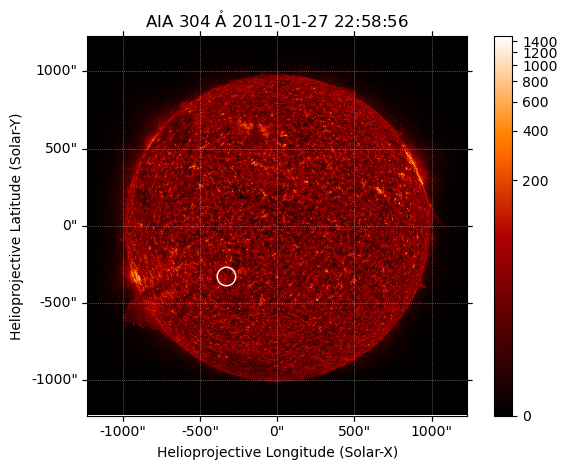

In [4]:
fig=plt.figure()
ax = fig.add_subplot(projection=smap)
smap.plot(ax,vmax=1500,vmin=0)
# draw a circle around 2000,2000
circle = plt.Circle((1500, 1500), 100, color='white', fill=False)
ax.add_artist(circle)

plt.colorbar()

plt.tight_layout()
fig.savefig('data_utils\output\eps\single\sun.eps')


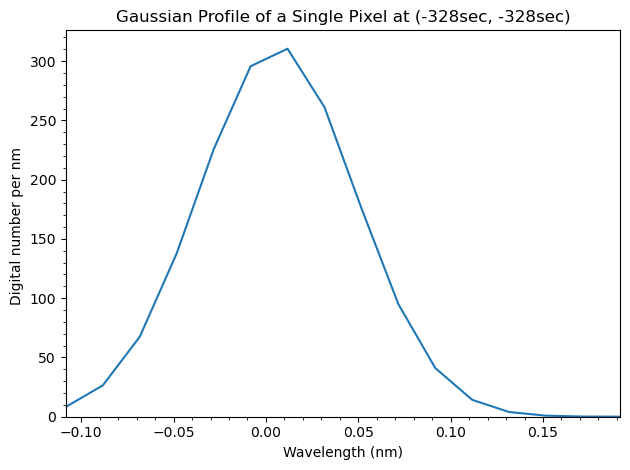

In [77]:
def wavelength_shift(Tx, Ty, A, B):
    return A * Tx**2 + B * Ty
def my_Gaussian1D(wavelength_list, amplitude, mean, stddev):
    return amplitude * np.exp(-((wavelength_list - mean)**2 / (2 * stddev**2)))

# take one pixel , construct a Gaussian profile and visualize it

mu=wavelength_shift(smap.pixel_to_world(1500*u.pix,1500*u.pix).Tx.value*2*np.pi/(3600*180),
                    smap.pixel_to_world(1500*u.pix,1500*u.pix).Ty.value*2*np.pi/(3600*180),
                    A=886.81,B=0.91002)
stddev=0.1 *gaussian_fwhm_to_sigma
amplitude=image[1500,1500]/(2*np.sqrt(2 * cp.pi) * stddev)

fig,ax=plt.subplots()
ax.plot(wavelength_list_aia_relative_Single_A,my_Gaussian1D(wavelength_list_aia_relative_Single_A,amplitude,mu,stddev))
pixel_info=smap.pixel_to_world(1500*u.pix,1500*u.pix)
ax.set_title("Gaussian Profile of a Single Pixel at ("+str(int(pixel_info.Tx.value))+"sec, "+str(int(pixel_info.Ty.value))+"sec)")
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital number per nm ")
ax.set_xlim(wavelength_list_aia_relative_Single_A.min(),wavelength_list_aia_relative_Single_A.max())
ax.set_ylim(0,None)

# add minor and major ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(50))
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))

plt.tight_layout()
fig.savefig('data_utils\output\eps\single\pixel.eps')

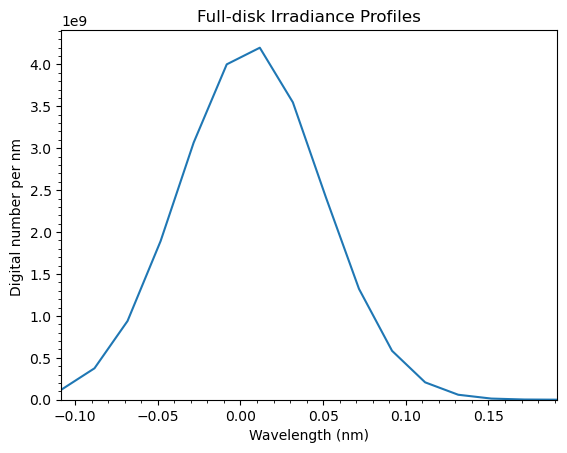

In [76]:
irradiance=calculating_DN(image,wavelength_list_aia_relative_Single_A,0,0,dtype=cp.float32)
fig,ax=plt.subplots()
ax.plot(wavelength_list_aia_relative_Single_A,irradiance)
ax.set_title("Full-disk Irradiance Profiles")
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital number per nm ")
ax.set_xlim(wavelength_list_aia_relative_Single_A.min(),wavelength_list_aia_relative_Single_A.max())
ax.set_ylim(0,None)

# add minor and major ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(5e8))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1e8))

plt.show()
fig.savefig("data_utils\output\eps\single\\full_disk.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


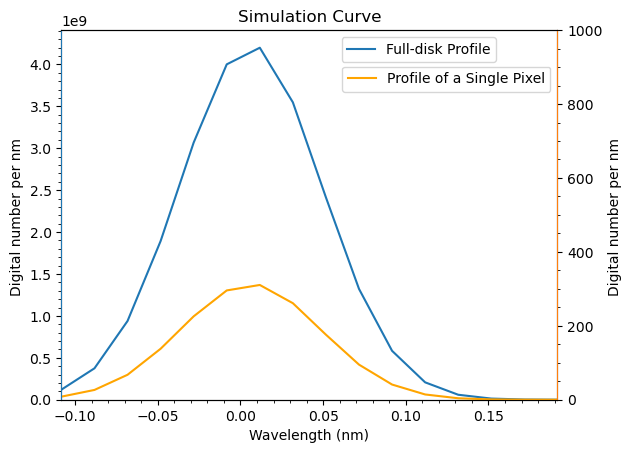

In [75]:
# draw a figure of 2 curves with left and right y axis
fig,ax1=plt.subplots()
ax2=ax1.twinx()
ax1.plot(wavelength_list_aia_relative_Single_A,irradiance,label='Full-disk Profile')
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel("Digital number per nm ")
ax1.set_xlim(wavelength_list_aia_relative_Single_A.min(),wavelength_list_aia_relative_Single_A.max())
ax1.set_ylim(0,None)


ax2.plot(wavelength_list_aia_relative_Single_A,my_Gaussian1D(wavelength_list_aia_relative_Single_A,amplitude,mu,stddev),
         color='orange',label='Profile of a Single Pixel')
ax2.set_title("Simulation Curve")
ax2.set_ylabel("Digital number per nm ")
ax2.set_ylim(0,1e3)

# add minor and major ticks
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax1.yaxis.set_major_locator(plt.MultipleLocator(5e8))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(1e8))
ax2.yaxis.set_major_locator(plt.MultipleLocator(200))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(50))

#set the right y axis C0, and the left y axis C1. Ticks remain black
ax2.spines['left'].set_color('C0')
ax2.spines['right'].set_color('C1')


# show the legend of the 2 curves, do not overlap with the curves
ax1.legend(bbox_to_anchor=(0.8906,1))
ax2.legend(bbox_to_anchor=(1,0.92))

fig.savefig("data_utils\output\eps\single\\simulation.eps")

In [2]:
# Cruciformscan in alpha direction
angle_point_num_alpha = 61
offaxis_angle_x_alpha = np.linspace(-np.pi /
                                    360, np.pi/360, angle_point_num_alpha)
offaxis_angle_y_alpha = np.zeros(angle_point_num_alpha)

# Cruciformscan in beta direction
angle_point_num_beta = 61
offaxis_angle_x_beta = np.zeros(angle_point_num_beta)
offaxis_angle_y_beta = np.linspace(-np.pi /
                                   360, np.pi/360, angle_point_num_beta)

In [3]:
def calculate_DN(image,wavelength_list,angle_x,angle_y,A):
    output=[]
    for i in range(len(angle_x)):
        output.append(calculating_DN(image,wavelength_list,angle_x[i],angle_y[i],A=A))
    return np.array(output)

In [6]:
output_alpha=calculate_DN(image,wavelength_list_aia_relative_Single_A,offaxis_angle_x_alpha,offaxis_angle_y_alpha,A=886.81)

In [7]:
output_beta=calculate_DN(image,wavelength_list_aia_relative_Single_A,offaxis_angle_x_beta,offaxis_angle_y_beta,A=886.81)

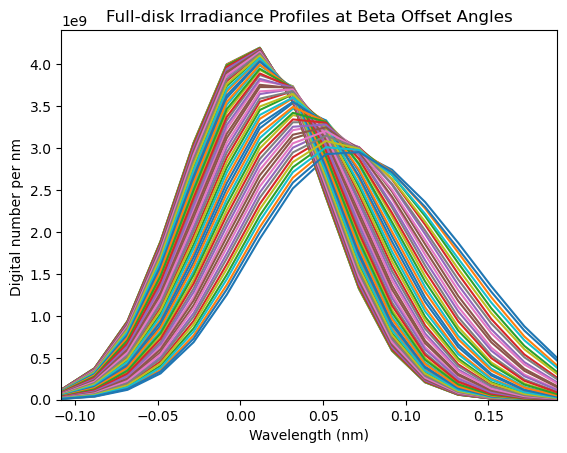

In [149]:
fig,ax=plt.subplots()
for i in range(output_alpha.shape[0]):
    ax.plot(wavelength_list_aia_relative_Single_A,output_alpha[i])

ax.set_title("Full-disk Irradiance Profiles at Beta Offset Angles")
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital number per nm ")
ax.set_xlim(wavelength_list_aia_relative_Single_A.min(),wavelength_list_aia_relative_Single_A.max())
ax.set_ylim(0,None)

fig.savefig("data_utils\output\png\single\\alpha.png",dpi=800)


C:\Users\14902\AppData\Local\Temp\ipykernel_16208\1279621367.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm)


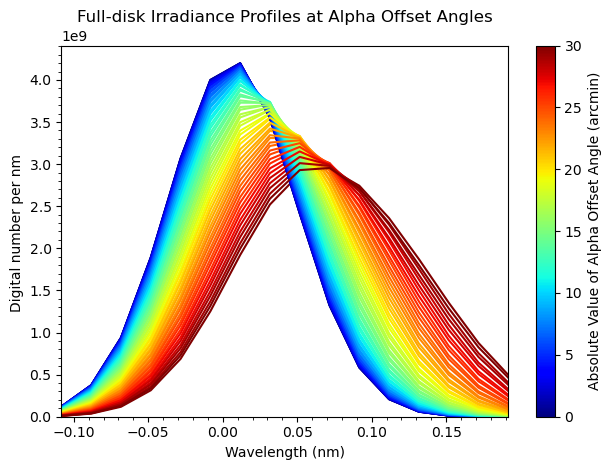

In [160]:
# offaxis_angle_x_alpha = np.linspace(-np.pi /360, np.pi/360, angle_point_num_alpha)
# get a absolute value of offaxis_angle_x_alpha, and 
uniform_angle=np.abs(offaxis_angle_x_alpha)*180*60/np.pi/30
# print(uniform_angle)


fig,ax=plt.subplots()

# for i in range(output_alpha.shape[0]):
#     ax.plot(wavelength_list_aia_relative_Single_A,output_alpha[i])
# plot it with a color chart: from start to end it changes continuously
# plot the color bar

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))

for i in list(range(output_alpha.shape[0]))[:]:
    ax.plot(wavelength_list_aia_relative_Single_A,output_alpha[i],color=sm.to_rgba(uniform_angle[i]))

# show a colorbar
cbar=plt.colorbar(sm)
# set colorbar ticks at np.linspace(0,1,61)
cbar.set_ticks(np.linspace(0,1,61)[::10])
# set ticklabels to be angle_point_num_alpha
cbar.set_ticklabels(np.linspace(0,30,61,dtype=int)[::10])
# add a title to the colorbar "Absolute Value of Alpha Offset Angle (arcmin)"
cbar.set_label("Absolute Value of Alpha Offset Angle (arcmin)")

ax.set_title("Full-disk Irradiance Profiles at Alpha Offset Angles")
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital number per nm ")
ax.set_xlim(wavelength_list_aia_relative_Single_A.min(),wavelength_list_aia_relative_Single_A.max())
ax.set_ylim(0,None)

# add minor and major ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(5e8))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1e8))

plt.tight_layout()
fig.savefig("data_utils\output\eps\single\\alpha.eps")

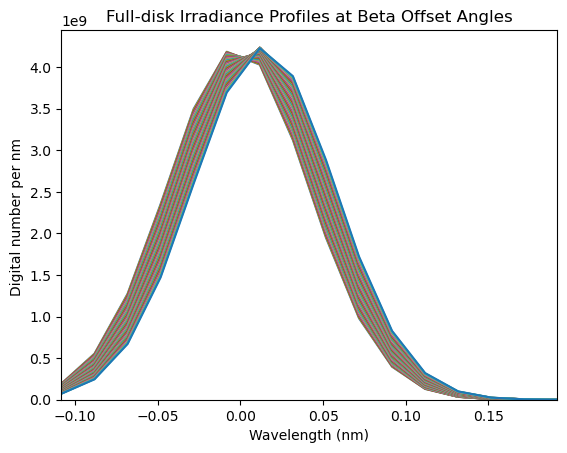

In [88]:
fig,ax=plt.subplots()
for i in range(output_beta.shape[0]):
    ax.plot(wavelength_list_aia_relative_Single_A,output_beta[i])

ax.set_title("Full-disk Irradiance Profiles at Beta Offset Angles")
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital number per nm ")
ax.set_xlim(wavelength_list_aia_relative_Single_A.min(),wavelength_list_aia_relative_Single_A.max())
ax.set_ylim(0,None)

fig.savefig("data_utils\output\single\\beta.png",dpi=800)

C:\Users\14902\AppData\Local\Temp\ipykernel_16208\3055346266.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm)


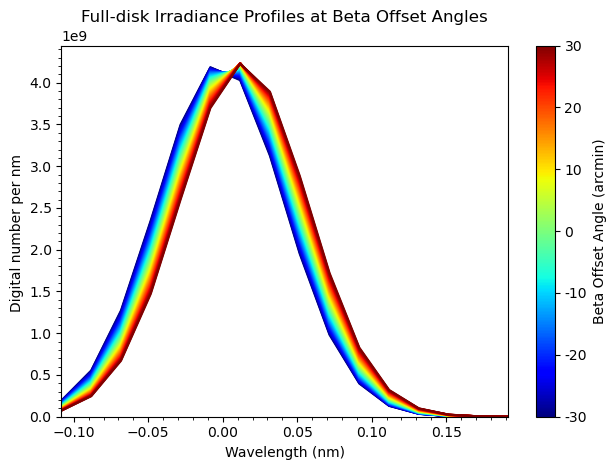

In [162]:
# offaxis_angle_y_beta = np.linspace(-np.pi /360, np.pi/360, angle_point_num_alpha)
# get a absolute value of offaxis_angle_x_alpha, and 
uniform_angle=offaxis_angle_y_beta*180*60/np.pi/60+0.5
# print(uniform_angle)


fig,ax=plt.subplots()

# for i in range(output_alpha.shape[0]):
#     ax.plot(wavelength_list_aia_relative_Single_A,output_alpha[i])
# plot it with a color chart: from start to end it changes continuously
# plot the color bar

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=1))

for i in list(range(output_alpha.shape[0]))[:]:
    ax.plot(wavelength_list_aia_relative_Single_A,output_beta[i],color=sm.to_rgba(uniform_angle[i]))

# show a colorbar
cbar=plt.colorbar(sm)
# set colorbar ticks at np.linspace(0,1,61)
cbar.set_ticks(np.linspace(0,1,61)[::10])
# set ticklabels to be angle_point_num_alpha
cbar.set_ticklabels(np.linspace(-30,30,61,dtype=int)[::10])
# add a title to the colorbar "Absolute Value of Alpha Offset Angle (arcmin)"
cbar.set_label("Beta Offset Angle (arcmin)")

ax.set_title("Full-disk Irradiance Profiles at Beta Offset Angles")
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("Digital number per nm ")
ax.set_xlim(wavelength_list_aia_relative_Single_A.min(),wavelength_list_aia_relative_Single_A.max())
ax.set_ylim(0,None)

# add minor and major ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(5e8))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1e8))

plt.tight_layout()
fig.savefig("data_utils\output\eps\single\\beta.eps")


In [56]:
output_alpha.shape

(61, 16)

In [58]:
offaxis_angle_x_alpha.shape

(61,)

In [60]:
# 16 row 2 column
gaussian
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,9.219017e+06,3.655149e+07,1.182795e+08,3.138383e+08,6.871013e+08,1.251933e+09,1.920739e+09,2.520380e+09,2.885153e+09,2.946970e+09,2.743226e+09,2.358001e+09,1.871704e+09,1.354602e+09,8.761894e+08,4.960543e+08
1,1.122968e+07,4.356918e+07,1.379693e+08,3.582730e+08,7.677956e+08,1.369833e+09,2.058938e+09,2.648685e+09,2.974481e+09,2.980778e+09,2.718262e+09,2.280125e+09,1.755036e+09,1.222244e+09,7.549947e+08,4.055447e+08
2,1.353011e+07,5.143435e+07,1.595824e+08,4.060296e+08,8.526648e+08,1.491039e+09,2.197415e+09,2.772948e+09,3.055510e+09,3.002885e+09,2.679632e+09,2.189434e+09,1.630666e+09,1.090636e+09,6.424356e+08,3.271263e+08
3,1.613240e+07,6.016303e+07,1.831087e+08,4.569991e+08,9.414174e+08,1.615056e+09,2.335549e+09,2.892494e+09,3.127513e+09,3.012630e+09,2.627257e+09,2.087147e+09,1.501173e+09,9.626108e+08,5.400795e+08,2.605413e+08
4,1.904420e+07,6.975901e+07,2.085136e+08,5.110387e+08,1.033732e+09,1.741380e+09,2.472715e+09,3.006629e+09,3.189759e+09,3.009482e+09,2.561424e+09,1.974941e+09,1.369306e+09,8.406311e+08,4.488302e+08,2.050587e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.083021e+07,7.553678e+07,2.235344e+08,5.424035e+08,1.086195e+09,1.811076e+09,2.544338e+09,3.058631e+09,3.205001e+09,2.983732e+09,2.504588e+09,1.905439e+09,1.305397e+09,7.933609e+08,4.200825e+08,1.905639e+08
57,1.771451e+07,6.537782e+07,1.969302e+08,4.864539e+08,9.918044e+08,1.683810e+09,2.408880e+09,2.949566e+09,3.150346e+09,2.994683e+09,2.575630e+09,2.018448e+09,1.433907e+09,9.098478e+08,5.060523e+08,2.423307e+08
58,1.491660e+07,5.609685e+07,1.721966e+08,4.334946e+08,9.007498e+08,1.558436e+09,2.271896e+09,2.834563e+09,3.085724e+09,2.993131e+09,2.634256e+09,2.122870e+09,1.561053e+09,1.032663e+09,6.027617e+08,3.045758e+08
59,1.243128e+07,4.769725e+07,1.493841e+08,3.836940e+08,8.133834e+08,1.435482e+09,2.134011e+09,2.714267e+09,3.011742e+09,2.979425e+09,2.680031e+09,2.217037e+09,1.684284e+09,1.159604e+09,7.094734e+08,3.780492e+08


In [9]:
def gaussian_function(x, amplitude, mean, stddev):
    # A refers to Amplitude, the peak value!   not the integrated area!
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))


def gaussian_fit(wavelength_list, irradiance):
    '''
    Fit a Gaussian function to the given irradiance data.

    Parameters
    ----------
    irradiance : (12,) ndarray
        A 1D array of irradiance data to fit the Gaussian function to.

    Returns
    -------
    float
        The mean value of the fitted Gaussian function.

    Notes
    -----
    The function uses the astropy modeling and fitting library to perform the fitting. It sets the initial parameters of the Gaussian function to amplitude=1E9, mean=0.05, and stddev=0.0424, and uses the LevMarLSQFitter algorithm for fitting.

    The function also imports a pre-defined list of wavelengths from the constant module, which is used to evaluate the fitted Gaussian function.

    '''
    
    # Perform the curve fitting


    #check whether input contain nan
    try:
        if np.any(np.isnan(irradiance)):
            raise ValueError("Input data contains NaN values.")

        p0 = [1e9, 0, 0.03]  # Initial guess for the parameters [amplitude, mean, stddev]
        popt, pcov = curve_fit(gaussian_function, wavelength_list, irradiance, p0=p0)

        return popt

    except :
        return np.full((3, ), np.nan), np.full((3, 3), np.nan)

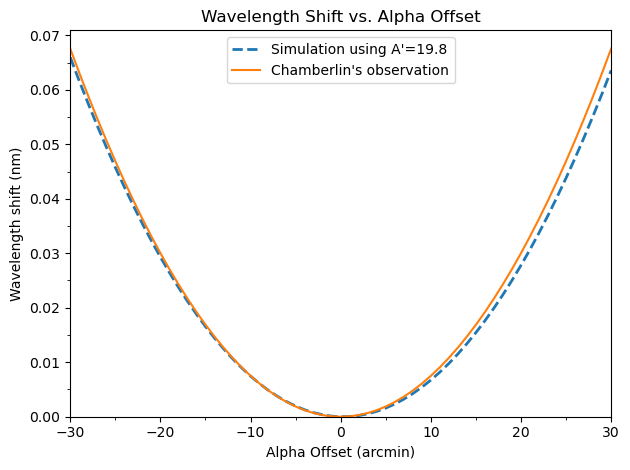

In [12]:
central_list=[]
for i in range(output_alpha.shape[0]):
    central_list.append(gaussian_fit(wavelength_list_aia_relative_Single_A,output_alpha[i])[1])
    
    
fig,ax=plt.subplots()
# dashed line
ax.plot(offaxis_angle_x_alpha*180*60/np.pi,
        central_list-np.min(central_list),
        label="Simulation using A'=19.8",
        linestyle='dashed',
        linewidth=2,)


ax.plot(offaxis_angle_x_alpha*180*60/np.pi,
        886.81*offaxis_angle_x_alpha**2,
        label="Chamberlin's observation",)




ax.set_xlabel("Alpha Offset (arcmin)")
ax.set_ylabel('Wavelength shift (nm)')
#谱线中心波长与入射偏角的关系
ax.set_title("Wavelength Shift vs. Alpha Offset")
ax.set_xlim(-30,30)
ax.set_ylim(0,None)

# add major and minor ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.005))
ax.legend()

plt.tight_layout()
fig.savefig("data_utils\output\png\single\\alpha_shift.png")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


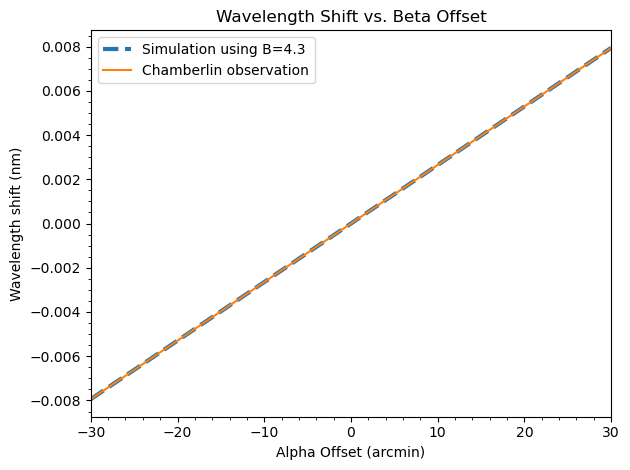

In [173]:
central_list=[]
for i in range(output_beta.shape[0]):
    central_list.append(gaussian_fit(wavelength_list_aia_relative_Single_A,output_beta[i])[1])


fig,ax=plt.subplots()


# dashed line
ax.plot(offaxis_angle_y_beta*180*60/np.pi,
                central_list-central_list[30],
        label="Simulation using B=4.3",
        linestyle='dashed',
        linewidth=3,)

ax.plot(offaxis_angle_y_beta*180*60/np.pi,
        0.91002*offaxis_angle_y_beta,
        label="Chamberlin observation",)


ax.set_xlabel("Alpha Offset (arcmin)")
ax.set_ylabel('Wavelength shift (nm)')
#谱线中心波长与入射偏角的关系
ax.set_title("Wavelength Shift vs. Beta Offset")
ax.set_xlim(-30,30)
# ax.set_ylim(0,None)

# add major and minor ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.002))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.0005))
ax.legend()

plt.tight_layout()
fig.savefig("data_utils\output\eps\single\\beta_shift.eps")

# Multiple A

In [16]:
aia_file = 'data_utils\\data\\AIA\\aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits'
smap = sunpy.map.Map(aia_file)
image=smap.data


# Cruciformscan in alpha direction
angle_point_num_alpha = 61
offaxis_angle_x_alpha = np.linspace(-np.pi /
                                    360, np.pi/360, angle_point_num_alpha)
offaxis_angle_y_alpha = np.zeros(angle_point_num_alpha)

# Cruciformscan in beta direction
angle_point_num_beta = 61
offaxis_angle_x_beta = np.zeros(angle_point_num_beta)
offaxis_angle_y_beta = np.linspace(-np.pi /
                                   360, np.pi/360, angle_point_num_beta)


def calculate_DN(image,wavelength_list,angle_x,angle_y,A):
    output=[]
    for i in range(len(angle_x)):
        output.append(calculating_DN(image,wavelength_list,angle_x[i],angle_y[i],A=A))
    return np.array(output)


def gaussian_function(x, amplitude, mean, stddev):
    # A refers to Amplitude, the peak value!   not the integrated area!
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))


def gaussian_fit(wavelength_list, irradiance):
    '''
    Fit a Gaussian function to the given irradiance data.

    Parameters
    ----------
    irradiance : (12,) ndarray
        A 1D array of irradiance data to fit the Gaussian function to.

    Returns
    -------
    float
        The mean value of the fitted Gaussian function.

    Notes
    -----
    The function uses the astropy modeling and fitting library to perform the fitting. It sets the initial parameters of the Gaussian function to amplitude=1E9, mean=0.05, and stddev=0.0424, and uses the LevMarLSQFitter algorithm for fitting.

    The function also imports a pre-defined list of wavelengths from the constant module, which is used to evaluate the fitted Gaussian function.

    '''
    
    # Perform the curve fitting


    #check whether input contain nan
    try:
        if np.any(np.isnan(irradiance)):
            raise ValueError("Input data contains NaN values.")

        p0 = [1e9, 0, 0.03]  # Initial guess for the parameters [amplitude, mean, stddev]
        popt, pcov = curve_fit(gaussian_function, wavelength_list, irradiance, p0=p0)

        return popt

    except :
        return np.full((3, ), np.nan), np.full((3, 3), np.nan)

In [8]:
A_list=np.linspace(800,1000,num=40)
irradiance_list=[]
for A in A_list:
    irradiance=calculate_DN(image,wavelength_list_aia_relative_Single_A,offaxis_angle_x_alpha,offaxis_angle_y_alpha,A) 
    irradiance_list.append(irradiance)

In [9]:
df={'A':A_list,
    'irradiance':irradiance_list,
    }
df=pd.DataFrame(df)
df

# save into a pkl
df.to_pickle('data_utils\\data\\output\\alpha.pkl')

In [28]:
#read from pkl file
df=pd.read_pickle('data_utils\\data\\output\\alpha.pkl')
df

,A,irradiance
0,800.000000,"[[11189033.315814707, 43717118.92569611, 13939..."
1,805.128205,"[[11059167.89914795, 43247544.983924486, 13802..."
2,810.256410,"[[10931149.687704261, 42784289.242308244, 1366..."
3,815.384615,"[[10804945.37674316, 42327241.64864049, 135321..."
4,820.512821,"[[10680522.420175752, 41876294.59890463, 13399..."
5,825.641026,"[[10557849.009365484, 41431342.87053822, 13268..."
6,830.769231,"[[10436894.05262902, 40992283.55782023, 131398..."
7,835.897436,"[[10317627.155411262, 40559016.009307384, 1301..."
8,841.025641,"[[10200018.601108907, 40131441.76724688, 12886..."
9,846.153846,"[[10084039.332518442, 39709464.50889628, 12762..."


In [13]:
df.iloc[0]['irradiance']

array([[1.11890333e+07, 4.37171189e+07, 1.39396064e+08, 3.64415098e+08,
        7.85969959e+08, 1.41050004e+09, 2.13049102e+09, 2.74943914e+09,
        3.08767936e+09, 3.07738079e+09, 2.76724146e+09, 2.26240899e+09,
        1.67482811e+09, 1.10724612e+09, 6.41967924e+08, 3.20728732e+08],
       [1.34051077e+07, 5.13454343e+07, 1.60496982e+08, 4.11332561e+08,
        8.69815435e+08, 1.53073516e+09, 2.26790786e+09, 2.87147709e+09,
        3.16338018e+09, 3.08946723e+09, 2.71472910e+09, 2.15850216e+09,
        1.54432158e+09, 9.80220531e+08, 5.42379249e+08, 2.57343096e+08],
       [1.59063878e+07, 5.97950972e+07, 1.83429120e+08, 4.61340685e+08,
        9.57398300e+08, 1.65361158e+09, 2.40470872e+09, 2.98828258e+09,
        3.22928845e+09, 3.08861253e+09, 2.64899466e+09, 2.04528634e+09,
        1.41212720e+09, 8.59527451e+08, 4.53564990e+08, 2.04326490e+08],
       [1.87013722e+07, 6.90733838e+07, 2.08167274e+08, 5.14313702e+08,
        1.04841545e+09, 1.77862500e+09, 2.54023608e+09, 3.099

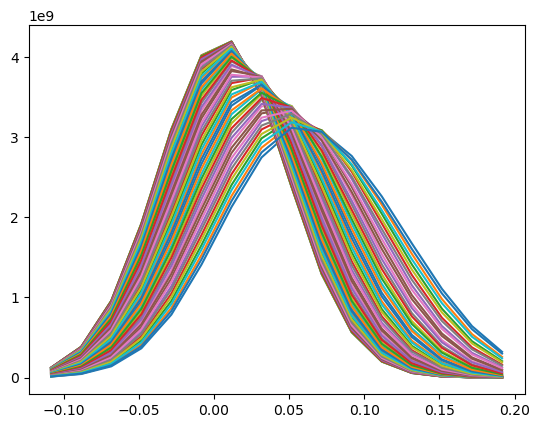

In [14]:
fig,ax=plt.subplots()
for i in range(df.iloc[0]['irradiance'].shape[0]):
    ax.plot(wavelength_list_aia_relative_Single_A,df.iloc[0]['irradiance'][i])

In [54]:
df={'A':A_list,
    'irradiance':irradiance_list,
    'A_out':np.nan}
df=pd.DataFrame(df)
df.set_index('A',inplace=True)
df

,irradiance,A_out
A,,
800.0,"[[9219016.865090583, 36551488.31210879, 118279...",NaN
1000.0,"[[9219016.865090583, 36551488.31210879, 118279...",NaN


# Analysis from multiple A

In [17]:
temp_coeff_list=[]
for a in df.index:
    temp_coeff_list.append([            gaussian_fit(wavelength_list_aia_relative_Single_A,df.loc[a,'irradiance'][i])[1]
                            for i in range(df.loc[a,'irradiance'].shape[0])    ])

In [18]:
# add a col in df
df['temp_coeff']=temp_coeff_list
df

,A,irradiance,temp_coeff
0,800.000000,"[[11189033.315814707, 43717118.92569611, 13939...","[0.06541146561214818, 0.0614838174206048, 0.05..."
1,805.128205,"[[11059167.89914795, 43247544.983924486, 13802...","[0.06581047691825234, 0.061858380759967954, 0...."
2,810.256410,"[[10931149.687704261, 42784289.242308244, 1366...","[0.06620920489943909, 0.06223268771569415, 0.0..."
3,815.384615,"[[10804945.37674316, 42327241.64864049, 135321...","[0.06660764525430445, 0.06260673658152638, 0.0..."
4,820.512821,"[[10680522.420175752, 41876294.59890463, 13399...","[0.06700579325891959, 0.06298052546440705, 0.0..."
5,825.641026,"[[10557849.009365484, 41431342.87053822, 13268...","[0.06740364367068957, 0.06335405211437686, 0.0..."
6,830.769231,"[[10436894.05262902, 40992283.55782023, 131398...","[0.06780119081945489, 0.0637273140250563, 0.05..."
7,835.897436,"[[10317627.155411262, 40559016.009307384, 1301...","[0.06819842841802844, 0.06410030833671623, 0.0..."
8,841.025641,"[[10200018.601108907, 40131441.76724688, 12886...","[0.06859534966433593, 0.0644730319175742, 0.06..."
9,846.153846,"[[10084039.332518442, 39709464.50889628, 12762...","[0.06899194725506747, 0.06484548130717047, 0.0..."


In [22]:
A_out_list=[]
for a in df.index:
    A_out_list.append(np.polyfit(offaxis_angle_x_alpha,df.loc[a,'temp_coeff'],2)[0])

In [23]:
A_out_list

[770.8057705821177,
 775.461585663854,
 780.1136245589752,
 784.7619073496495,
 789.4064158186732,
 794.0471321905264,
 798.6840388202024,
 803.3171796188278,
 807.9464082476532,
 812.571761377549,
 817.1932481867444,
 821.8107570629817,
 826.4242716234886,
 831.0337480642097,
 835.6391510463868,
 840.2404357394217,
 844.8375232745205,
 849.4303659054557,
 854.0188846416619,
 858.6030228627131,
 863.1827193627079,
 867.7579239306523,
 872.3284581708247,
 876.8943318641033,
 881.4553935570658,
 886.0115749052072,
 890.562726221899,
 895.1086443413886,
 899.6494012446979,
 904.1848559157851,
 908.7147104650229,
 913.2389377757497,
 917.7573513164859,
 922.2698036158096,
 926.776120874428,
 931.2761695459075,
 935.7697785991298,
 940.2567351101712,
 944.7368636154222,
 949.2099831705087]

In [24]:
df['A_out']=A_out_list

In [25]:
df

,A,irradiance,temp_coeff,A_out
0,800.000000,"[[11189033.315814707, 43717118.92569611, 13939...","[0.06541146561214818, 0.0614838174206048, 0.05...",770.805771
1,805.128205,"[[11059167.89914795, 43247544.983924486, 13802...","[0.06581047691825234, 0.061858380759967954, 0....",775.461586
2,810.256410,"[[10931149.687704261, 42784289.242308244, 1366...","[0.06620920489943909, 0.06223268771569415, 0.0...",780.113625
3,815.384615,"[[10804945.37674316, 42327241.64864049, 135321...","[0.06660764525430445, 0.06260673658152638, 0.0...",784.761907
4,820.512821,"[[10680522.420175752, 41876294.59890463, 13399...","[0.06700579325891959, 0.06298052546440705, 0.0...",789.406416
5,825.641026,"[[10557849.009365484, 41431342.87053822, 13268...","[0.06740364367068957, 0.06335405211437686, 0.0...",794.047132
6,830.769231,"[[10436894.05262902, 40992283.55782023, 131398...","[0.06780119081945489, 0.0637273140250563, 0.05...",798.684039
7,835.897436,"[[10317627.155411262, 40559016.009307384, 1301...","[0.06819842841802844, 0.06410030833671623, 0.0...",803.317180
8,841.025641,"[[10200018.601108907, 40131441.76724688, 12886...","[0.06859534966433593, 0.0644730319175742, 0.06...",807.946408
9,846.153846,"[[10084039.332518442, 39709464.50889628, 12762...","[0.06899194725506747, 0.06484548130717047, 0.0...",812.571761


In [26]:
df.to_pickle('data_utils\\data\\output\\Alpha_A.pkl')

In [27]:
df

,A,irradiance,temp_coeff,A_out
0,800.000000,"[[11189033.315814707, 43717118.92569611, 13939...","[0.06541146561214818, 0.0614838174206048, 0.05...",770.805771
1,805.128205,"[[11059167.89914795, 43247544.983924486, 13802...","[0.06581047691825234, 0.061858380759967954, 0....",775.461586
2,810.256410,"[[10931149.687704261, 42784289.242308244, 1366...","[0.06620920489943909, 0.06223268771569415, 0.0...",780.113625
3,815.384615,"[[10804945.37674316, 42327241.64864049, 135321...","[0.06660764525430445, 0.06260673658152638, 0.0...",784.761907
4,820.512821,"[[10680522.420175752, 41876294.59890463, 13399...","[0.06700579325891959, 0.06298052546440705, 0.0...",789.406416
5,825.641026,"[[10557849.009365484, 41431342.87053822, 13268...","[0.06740364367068957, 0.06335405211437686, 0.0...",794.047132
6,830.769231,"[[10436894.05262902, 40992283.55782023, 131398...","[0.06780119081945489, 0.0637273140250563, 0.05...",798.684039
7,835.897436,"[[10317627.155411262, 40559016.009307384, 1301...","[0.06819842841802844, 0.06410030833671623, 0.0...",803.317180
8,841.025641,"[[10200018.601108907, 40131441.76724688, 12886...","[0.06859534966433593, 0.0644730319175742, 0.06...",807.946408
9,846.153846,"[[10084039.332518442, 39709464.50889628, 12762...","[0.06899194725506747, 0.06484548130717047, 0.0...",812.571761


In [2]:
refit_df=pd.read_pickle('data_utils\\output\\Alpha_A.pkl')


In [3]:
refit_df

,A,irradiance,temp_coeff,A_out
0,800.000000,"[[11189033.315814707, 43717118.92569611, 13939...","[0.06541146561214818, 0.0614838174206048, 0.05...",770.805771
1,805.128205,"[[11059167.89914795, 43247544.983924486, 13802...","[0.06581047691825234, 0.061858380759967954, 0....",775.461586
2,810.256410,"[[10931149.687704261, 42784289.242308244, 1366...","[0.06620920489943909, 0.06223268771569415, 0.0...",780.113625
3,815.384615,"[[10804945.37674316, 42327241.64864049, 135321...","[0.06660764525430445, 0.06260673658152638, 0.0...",784.761907
4,820.512821,"[[10680522.420175752, 41876294.59890463, 13399...","[0.06700579325891959, 0.06298052546440705, 0.0...",789.406416
5,825.641026,"[[10557849.009365484, 41431342.87053822, 13268...","[0.06740364367068957, 0.06335405211437686, 0.0...",794.047132
6,830.769231,"[[10436894.05262902, 40992283.55782023, 131398...","[0.06780119081945489, 0.0637273140250563, 0.05...",798.684039
7,835.897436,"[[10317627.155411262, 40559016.009307384, 1301...","[0.06819842841802844, 0.06410030833671623, 0.0...",803.317180
8,841.025641,"[[10200018.601108907, 40131441.76724688, 12886...","[0.06859534966433593, 0.0644730319175742, 0.06...",807.946408
9,846.153846,"[[10084039.332518442, 39709464.50889628, 12762...","[0.06899194725506747, 0.06484548130717047, 0.0...",812.571761


In [93]:
refit_df['temp_coeff'][0]

[0.06541146561214818,
 0.0614838174206048,
 0.05769170158298108,
 0.054035287143541624,
 0.05051446694243731,
 0.047129036402030075,
 0.043878698201907124,
 0.04076314339901432,
 0.03778204748089633,
 0.03493507849123756,
 0.03222190216333194,
 0.029642177799489397,
 0.02719556794828509,
 0.024881733976116146,
 0.022700342057470534,
 0.02065106511766037,
 0.018733582265484553,
 0.0169475871667369,
 0.015292785221931624,
 0.013768896825295878,
 0.012375658895103591,
 0.01111282618363164,
 0.009980172265517149,
 0.008977490420066066,
 0.008104594230369614,
 0.0073613180735278725,
 0.006747517475254748,
 0.006263069386632476,
 0.005907872317582658,
 0.005681846526740027,
 0.005584934121475155,
 0.0056170991759987585,
 0.0057783278589208596,
 0.006068628554481645,
 0.006488032008253641,
 0.007036591453907967,
 0.007714382704898329,
 0.008521504265271146,
 0.009458077261109995,
 0.010524245410238421,
 0.011720174734175762,
 0.013046053195957997,
 0.014502090090226061,
 0.016088515209634873,

# refit Visualization

In [111]:
wavelength_list_aia_relative_Single_A

array([-0.1083, -0.0883, -0.0683, -0.0483, -0.0283, -0.0083,  0.0117,
        0.0317,  0.0517,  0.0717,  0.0917,  0.1117,  0.1317,  0.1517,
        0.1717,  0.1917])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


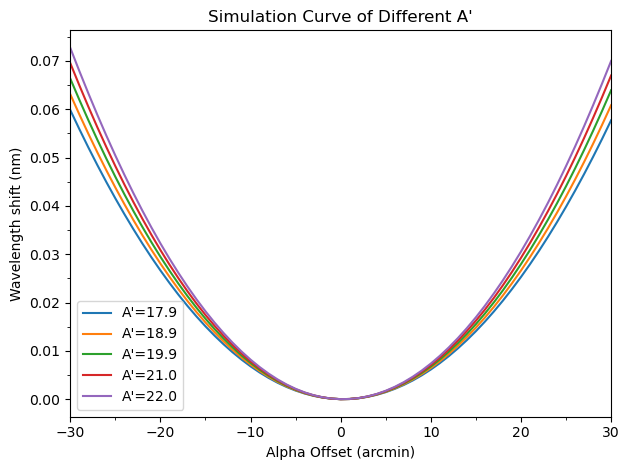

In [13]:
fig,ax=plt.subplots()
c=(180*3600/(974.634085*np.pi))**2 / 1000
for i in list(refit_df.index)[::9]:
    ax.plot(offaxis_angle_x_alpha*180*60/np.pi,
            refit_df.loc[i,'temp_coeff']-refit_df.loc[i,'temp_coeff'][30],
            label="A'={:.1f}".format(refit_df.loc[i,'A']/c))


ax.set_xlabel("Alpha Offset (arcmin)")
ax.set_ylabel('Wavelength shift (nm)')
ax.set_xlim(-30,30)

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.005))

ax.legend(loc='best')
ax.set_title("Simulation Curve of Different A'")
plt.tight_layout()
fig.savefig("data_utils\output\png\\multiple\\alpha_shift_A.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


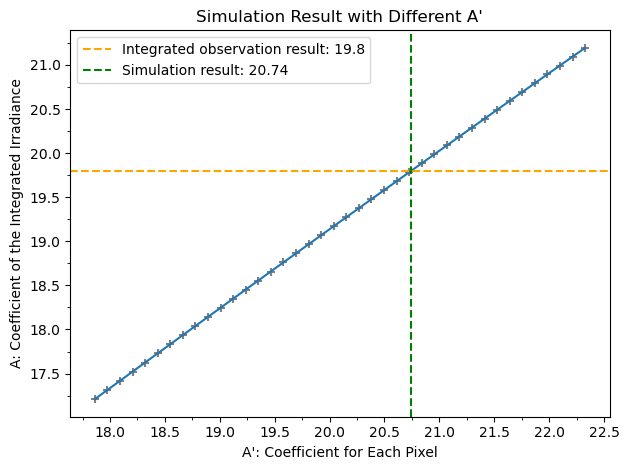

In [14]:
fig,ax=plt.subplots()
c=(180*3600/(974.634085*np.pi))**2 / 1000
ax.plot(refit_df['A']/c,refit_df['A_out']/c)
ax.scatter(refit_df['A']/c,refit_df['A_out']/c,marker='+',color='grey')

#draw a horiztonal dashed line at 19.8, with a clear text label
ax.axhline(y=19.8, color='orange', linestyle='--',label='Integrated observation result: 19.8')
#draw a vertical dashed line at ?
ax.axvline(x=20.74, color='green', linestyle='--',label='Simulation result: 20.74')

ax.set_xlabel("A': Coefficient for Each Pixel")
ax.set_ylabel('A: Coefficient of the Integrated Irradiance')

#make x tick denser
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))

ax.set_title("Simulation Result with Different A'")
# show legend
ax.legend()

plt.tight_layout()
fig.savefig('data_utils\output\eps\multiple\\simulation_A.eps')